In [1]:
# load in packages
from itertools import combinations

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [3]:
train_data.head(10)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2
5,9,No,0,1,41.189415,-0.905350,2,4,4,1
6,11,No,0,1,40.690409,1.085939,2,2,1,2
7,14,No,0,2,25.971529,-1.424817,1,3,3,2
8,15,Yes,0,2,31.930423,0.393317,2,3,1,2
9,16,No,0,1,27.474650,0.566472,2,2,3,2


In [4]:
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


## Q1: Analyze the results of the experiment and identify the effect of the Treatment on Product Purchase and Net Incremental Revenue

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


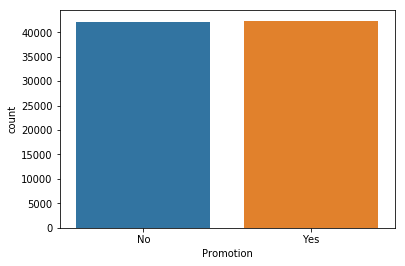

In [4]:
sb.countplot(data = train_data, x = 'Promotion')

Customers are approximately equally divided into the treatment and control groups.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


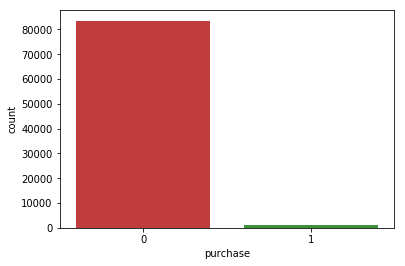

In [5]:
purch_palette = [sb.color_palette()[3], sb.color_palette()[2]]
sb.countplot(data = train_data, x = 'purchase', palette = purch_palette)

In [6]:
train_data['purchase'].mean()

0.012302742091939338

Only just over 1% of all customers made the purchase.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


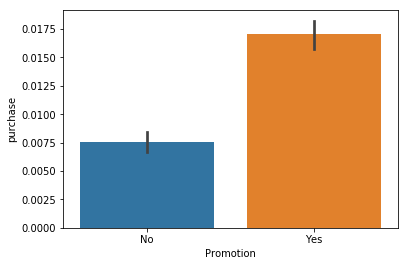

In [7]:
sb.barplot(data = train_data, x = 'Promotion', y = 'purchase')

In [8]:
# compute incremental response rate and net incremental revenue
def score(df):
    n_treat       = df.loc[df['Promotion'] == 'Yes',:].shape[0]
    n_control     = df.loc[df['Promotion'] == 'No',:].shape[0]
    n_treat_purch = df.loc[df['Promotion'] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df['Promotion'] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)

score(train_data)

(0.009454547819772702, -2334.5999999999995)

Customers in the promotion group were more than twice as likely to make a purchase as those in the control group. However, due to the low purchasing rate, the net effect is a negative net incremental revenue, $2,334.60 in losses. Focusing the treatment on only those users who would be most likely to respond to the promotion will make it a more effective program.

## Q2: Build a model to select the best customers to target that maximizes the Incremental Response Rate and Net Incremental Revenue.

### Exploring the Data

Features V2 and V3 will be treated as numeric, while the remaining predictor features (V1, V4, V5, V6, V7) will be treated as categorical.

In [9]:
def cat_feat_on_purchases(var):
    fig, ax = plt.subplots(ncols = 2, figsize = [12, 5])
    sb.countplot(data = train_data, x = var, hue = 'Promotion', ax = ax[0])
    sb.barplot(data = train_data, x = var, y = 'purchase', hue = 'Promotion', ax = ax[1])

def num_feat_on_purchases(var):
    fig, ax = plt.subplots(ncols = 2, figsize = [12, 5])
    sb.violinplot(data = train_data, y = 'Promotion', x = var, ax = ax[0])
    sb.violinplot(data = train_data, y = 'Promotion', x = var, hue = 'purchase',
                  palette = purch_palette, ax = ax[1])

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


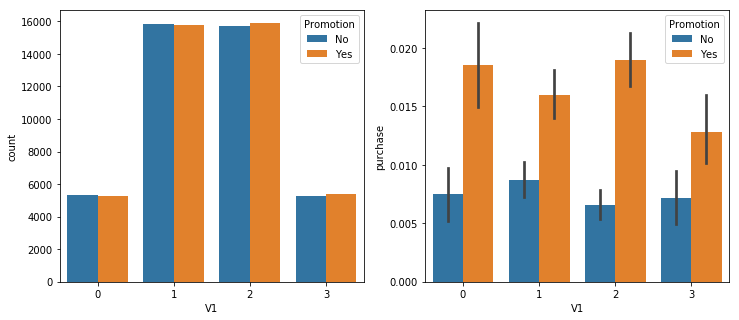

In [10]:
cat_feat_on_purchases('V1')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


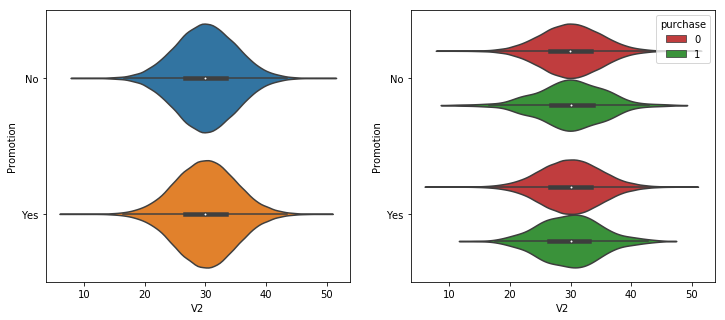

In [11]:
num_feat_on_purchases('V2')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


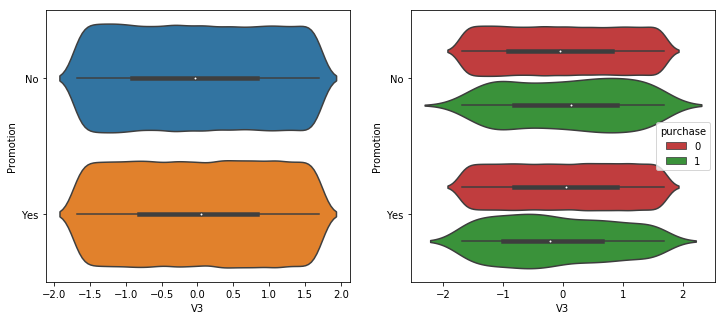

In [12]:
num_feat_on_purchases('V3')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


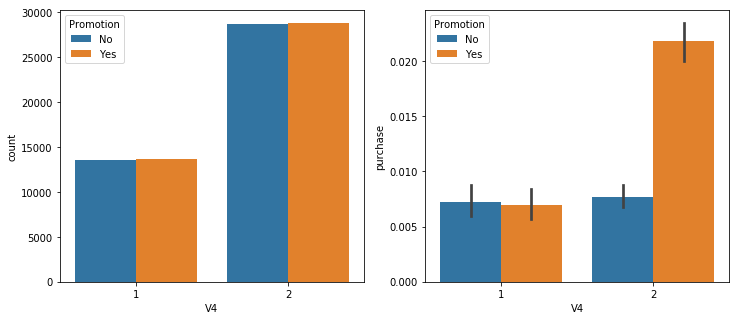

In [13]:
cat_feat_on_purchases('V4')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


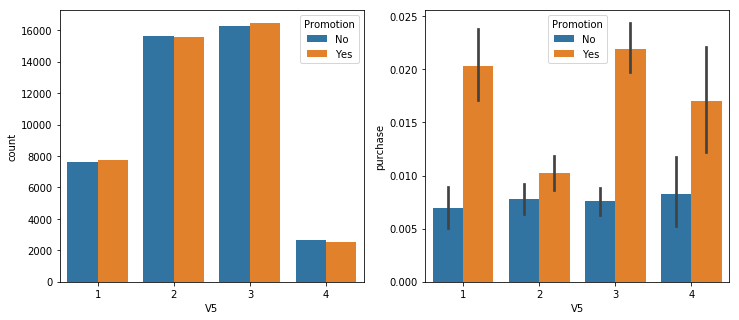

In [14]:
cat_feat_on_purchases('V5')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


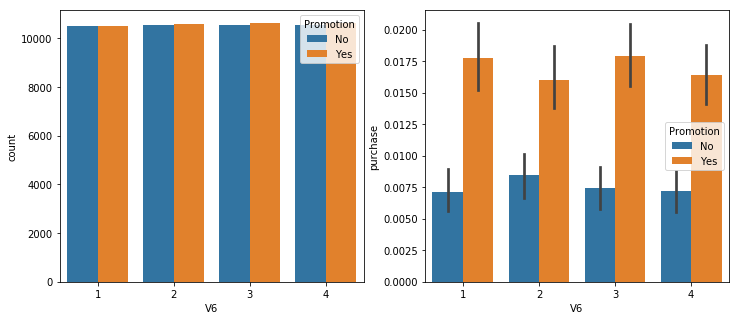

In [15]:
cat_feat_on_purchases('V6')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


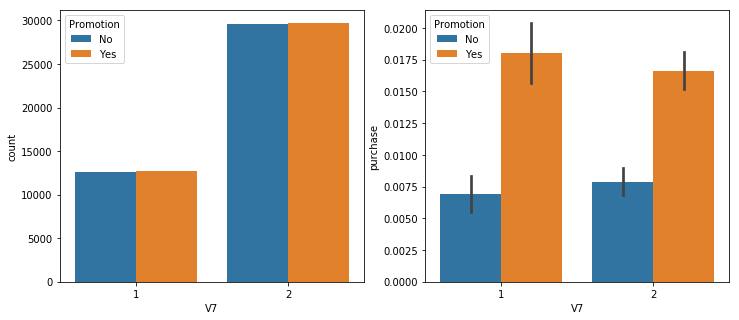

In [16]:
cat_feat_on_purchases('V7')

From a visual inspection, it looks like the data has been evenly divided not just on the number of customers in each condition, but also the marginal distributions for each individual feature. There might be feature interactions that aren't apparent from these plots, however.

Numeric features: In V2, there doesn't seem to be any bias in terms of which data points were more likely to make purchases, with or without the treatment. In V3, there doesn't seem to be any difference between treatment groups if the customer did not make a purchase, but for those that _did_ make a purchase, the feature values are slightly higher in the control group and lower in the treatment group.

Categorical features: The most dramatic effects can be seen in level 1 of V4 and level 2 of V5. In these categorical levels, there treatment did not have a significant effect on the proportion of customers making a purchase. The confidence bars on level 4 of V5 are also very large, producing an uncertain effect. For the other categorical features, the differences in treatment effectiveness is more subtle. On V1, it appears that the biggest gains are on level 0 and level 2. The effect is smallest on level 2 of V6, but still significant. In V7, the effect looks bigger on level 1 compared to level 2, but not by too much.

In [17]:
def heatmap_grid(x, y, **kwargs):
    """ Helper function for plotting heat maps in PairGrid """
    cat_cts = pd.concat([x,y], axis = 1).groupby([x, y]).size()
    cat_cts = cat_cts.reset_index(name = 'count')
    cat_cts = cat_cts.pivot(index = y.name, columns = x.name, values = 'count')
    sb.heatmap(cat_cts, **kwargs)

In [18]:
def chisquare_grid(x, y, **kwargs):
    """ Helper functions for posting chisqare test results to PairGrid """
    cat_cts = pd.concat([x,y], axis = 1).groupby([x, y]).size()
    cat_cts = cat_cts.reset_index(name = 'count')
    cat_cts = cat_cts.pivot(index = y.name, columns = x.name, values = 'count')
    chi2, p, dof, expected = sp.stats.chi2_contingency(cat_cts)
    plt.text(cat_cts.shape[1]/2, 0.35, "chi2 = {:0.2f}".format(chi2), ha = 'center')
    plt.text(cat_cts.shape[1]/2, 0.65, "p = {:0.3f}".format(p), ha = 'center')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


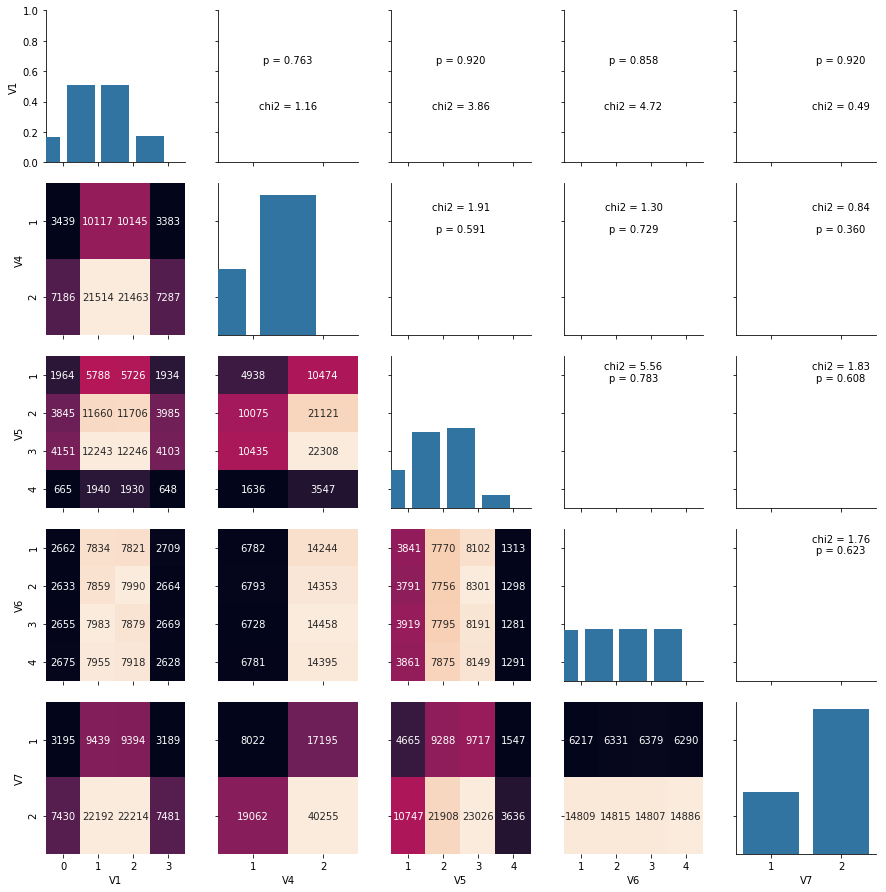

In [19]:
g = sb.PairGrid(data = train_data, vars = ['V1', 'V4', 'V5', 'V6', 'V7'])
g.map_diag(sb.countplot)
g.map_upper(chisquare_grid)
g.map_lower(heatmap_grid, annot = True, fmt = 'd', cbar = False);

Looks like there aren't any significant pairwise interactions between categorical variables.

In [20]:
def violin_grid(x, y, **kwargs):
    """ Quick hack for creating violin plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.violinplot(x, y, color = default_color)

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


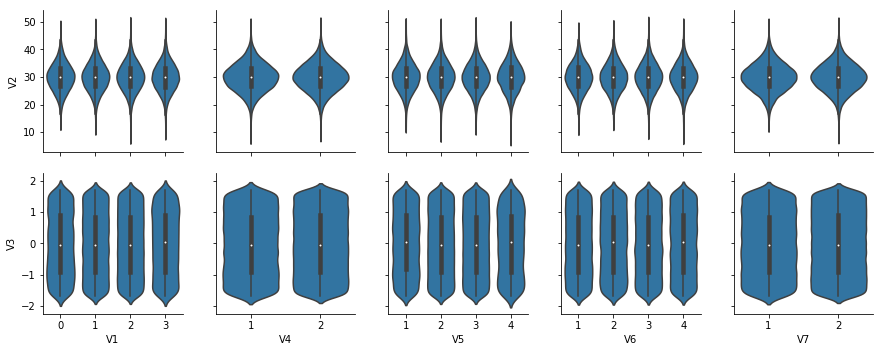

In [21]:
g = sb.PairGrid(data = train_data, y_vars = ['V2', 'V3'],
                x_vars = ['V1', 'V4', 'V5', 'V6', 'V7'])
g.map(violin_grid);

          V2        V3
V2  1.000000  0.001165
V3  0.001165  1.000000


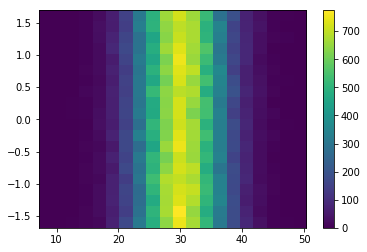

In [22]:
plt.hist2d(data = train_data, x = 'V2', y = 'V3', bins = 20)
plt.colorbar();
print(train_data[['V2','V3']].corr())

Neither does there appear to be any notable correlations between the numeric features to the categoricals, or between the two numeric features. Something like a decision tree model will probably be fine for selecting the best persons to include in the treatment.

### Modeling

For each feature, I compute the marginal benefit of the treatment. For categorical features, I look at the benefits of one category at a time. For the numeric features, I look at the benefit at various cutoff values.

In [23]:
def category_trim(df, var, in_levels):
    """
    Select observations to condition and treatment based on list
    of conditions specified for a single variable
    """
    # out_levels = np.setdiff1d(df[var].unique(), in_levels)
    # cont_in = df[var].isin(out_levels) & df['Promotion'].isin(['No'])
    # treat_in = df[var].isin(in_levels) & df['Promotion'].isin(['Yes'])
    # return df.loc[cont_in | treat_in, :]
    return df.loc[df[var].isin(in_levels)]

In [24]:
def score_catfilter(df, var):
    levels = df[var].unique()
    n_levels = levels.shape[0]
    for i in np.arange(1, n_levels):
        for perm in combinations(levels,int(i)):
            trim_df = category_trim(df, var, perm)
            n_treated = trim_df['Promotion'].isin(['Yes']).sum()
            n_control = trim_df['Promotion'].isin(['No']).sum()
            irr, nir = score(trim_df)
            print("Treatment for {} ({} in treatment): ".format(perm, n_treated))
            print("  iir = {:0.4f}, nir = {:.1f}".format(irr, nir))

In [25]:
score_catfilter(train_data, 'V1')

Treatment for (2,) (15900 in treatment): 
  iir = 0.0124, nir = -395.0
Treatment for (3,) (5389 in treatment): 
  iir = 0.0056, nir = -498.4
Treatment for (0,) (5283 in treatment): 
  iir = 0.0111, nir = -212.4
Treatment for (1,) (15792 in treatment): 
  iir = 0.0072, nir = -1228.8
Treatment for (2, 3) (21289 in treatment): 
  iir = 0.0107, nir = -893.3
Treatment for (2, 0) (21183 in treatment): 
  iir = 0.0121, nir = -607.4
Treatment for (2, 1) (31692 in treatment): 
  iir = 0.0098, nir = -1623.8
Treatment for (3, 0) (10672 in treatment): 
  iir = 0.0083, nir = -710.8
Treatment for (3, 1) (21181 in treatment): 
  iir = 0.0068, nir = -1727.2
Treatment for (0, 1) (21075 in treatment): 
  iir = 0.0082, nir = -1441.2
Treatment for (2, 3, 0) (26572 in treatment): 
  iir = 0.0108, nir = -1105.8
Treatment for (2, 3, 1) (37081 in treatment): 
  iir = 0.0092, nir = -2122.1
Treatment for (2, 0, 1) (36975 in treatment): 
  iir = 0.0100, nir = -1836.2
Treatment for (3, 0, 1) (26464 in treatment):

In [26]:
score_catfilter(train_data, 'V4')

Treatment for (1,) (13601 in treatment): 
  iir = -0.0003, nir = -2070.1
Treatment for (2,) (28763 in treatment): 
  iir = 0.0141, nir = -264.4


In [27]:
score_catfilter(train_data, 'V5')

Treatment for (1,) (7777 in treatment): 
  iir = 0.0134, nir = -116.5
Treatment for (3,) (16465 in treatment): 
  iir = 0.0143, nir = -99.8
Treatment for (4,) (2533 in treatment): 
  iir = 0.0087, nir = -169.9
Treatment for (2,) (15589 in treatment): 
  iir = 0.0025, nir = -1948.3
Treatment for (1, 3) (24242 in treatment): 
  iir = 0.0140, nir = -216.3
Treatment for (1, 4) (10310 in treatment): 
  iir = 0.0122, nir = -286.5
Treatment for (1, 2) (23366 in treatment): 
  iir = 0.0061, nir = -2064.9
Treatment for (3, 4) (18998 in treatment): 
  iir = 0.0136, nir = -269.7
Treatment for (3, 2) (32054 in treatment): 
  iir = 0.0086, nir = -2048.1
Treatment for (4, 2) (18122 in treatment): 
  iir = 0.0034, nir = -2118.3
Treatment for (1, 3, 4) (26775 in treatment): 
  iir = 0.0135, nir = -386.2
Treatment for (1, 3, 2) (39831 in treatment): 
  iir = 0.0095, nir = -2164.6
Treatment for (1, 4, 2) (25899 in treatment): 
  iir = 0.0064, nir = -2234.8
Treatment for (3, 4, 2) (34587 in treatment): 


In [28]:
score_catfilter(train_data, 'V6')

Treatment for (3,) (10623 in treatment): 
  iir = 0.0104, nir = -483.5
Treatment for (2,) (10595 in treatment): 
  iir = 0.0076, nir = -779.2
Treatment for (4,) (10628 in treatment): 
  iir = 0.0092, nir = -614.2
Treatment for (1,) (10518 in treatment): 
  iir = 0.0106, nir = -457.7
Treatment for (3, 2) (21218 in treatment): 
  iir = 0.0090, nir = -1262.7
Treatment for (3, 4) (21251 in treatment): 
  iir = 0.0098, nir = -1097.7
Treatment for (3, 1) (21141 in treatment): 
  iir = 0.0105, nir = -941.2
Treatment for (2, 4) (21223 in treatment): 
  iir = 0.0084, nir = -1393.4
Treatment for (2, 1) (21113 in treatment): 
  iir = 0.0091, nir = -1236.9
Treatment for (4, 1) (21146 in treatment): 
  iir = 0.0099, nir = -1071.9
Treatment for (3, 2, 4) (31846 in treatment): 
  iir = 0.0091, nir = -1876.9
Treatment for (3, 2, 1) (31736 in treatment): 
  iir = 0.0096, nir = -1720.4
Treatment for (3, 4, 1) (31769 in treatment): 
  iir = 0.0101, nir = -1555.3
Treatment for (2, 4, 1) (31741 in treatmen

In [29]:
score_catfilter(train_data, 'V7')

Treatment for (2,) (29705 in treatment): 
  iir = 0.0088, nir = -1845.8
Treatment for (1,) (12659 in treatment): 
  iir = 0.0111, nir = -488.8


There are no individual features that bring the net incremental revenue to positive, but there are some promising filter sets in V4 and V5 that might do the trick when combined.

In [30]:
def numeric_trim(df, var, op, val):
    """
    Select observations to condition and treatment based on list
    of conditions specified for a single variable
    """
    if op == ">":
        return df.loc[df[var] > val]
    #     cont_in = (df[var] <= val) & df['Promotion'].isin(['No'])
    #     treat_in = (df[var] > val) & df['Promotion'].isin(['Yes'])
    elif op == "<":
        return df.loc[df[var] < val]
    #     cont_in = (df[var] >= val) & df['Promotion'].isin(['No'])
    #     treat_in = (df[var] < val) & df['Promotion'].isin(['Yes'])
    # return df.loc[cont_in | treat_in, :]

def score_numfilter(df, var, values):
    for op in [">", "<"]:
        for val in values:
            trim_df = numeric_trim(df, var, op, val)
            n_treated = trim_df['Promotion'].isin(['Yes']).sum()
            n_control = trim_df['Promotion'].isin(['No']).sum()
            irr, nir = score(trim_df)
            print("Treatment for {} {:0.2f} ({} in treatment): ".format(op, val, n_treated))
            print("  iir = {:0.4f}, nir = {:.1f}".format(irr, nir))

In [31]:
score_numfilter(train_data, 'V2', np.arange(20,40+2,2))

Treatment for > 20.00 (41321 in treatment): 
  iir = 0.0096, nir = -2228.1
Treatment for > 22.00 (39982 in treatment): 
  iir = 0.0095, nir = -2177.3
Treatment for > 24.00 (37458 in treatment): 
  iir = 0.0096, nir = -2008.7
Treatment for > 26.00 (33286 in treatment): 
  iir = 0.0093, nir = -1902.9
Treatment for > 28.00 (27700 in treatment): 
  iir = 0.0088, nir = -1705.0
Treatment for > 30.00 (21145 in treatment): 
  iir = 0.0095, nir = -1151.8
Treatment for > 32.00 (14565 in treatment): 
  iir = 0.0093, nir = -814.8
Treatment for > 34.00 (8913 in treatment): 
  iir = 0.0077, nir = -657.0
Treatment for > 36.00 (4835 in treatment): 
  iir = 0.0072, nir = -375.2
Treatment for > 38.00 (2326 in treatment): 
  iir = 0.0101, nir = -108.9
Treatment for > 40.00 (1015 in treatment): 
  iir = 0.0122, nir = -22.2
Treatment for < 20.00 (1043 in treatment): 
  iir = 0.0038, nir = -106.4
Treatment for < 22.00 (2382 in treatment): 
  iir = 0.0082, nir = -157.3
Treatment for < 24.00 (4906 in treatmen

In [32]:
score_numfilter(train_data, 'V3', np.arange(-1.5,1.5+.2,.2))

Treatment for > -1.50 (39228 in treatment): 
  iir = 0.0089, nir = -2374.2
Treatment for > -1.30 (37121 in treatment): 
  iir = 0.0090, nir = -2208.1
Treatment for > -1.10 (34998 in treatment): 
  iir = 0.0088, nir = -2129.7
Treatment for > -0.90 (31840 in treatment): 
  iir = 0.0086, nir = -1986.0
Treatment for > -0.70 (29688 in treatment): 
  iir = 0.0084, nir = -1923.2
Treatment for > -0.50 (27574 in treatment): 
  iir = 0.0077, nir = -1986.1
Treatment for > -0.30 (25512 in treatment): 
  iir = 0.0075, nir = -1886.8
Treatment for > -0.10 (22326 in treatment): 
  iir = 0.0067, nir = -1828.9
Treatment for > 0.10 (20197 in treatment): 
  iir = 0.0060, nir = -1779.5
Treatment for > 0.30 (18166 in treatment): 
  iir = 0.0061, nir = -1574.9
Treatment for > 0.50 (14907 in treatment): 
  iir = 0.0056, nir = -1376.0
Treatment for > 0.70 (12744 in treatment): 
  iir = 0.0056, nir = -1181.6
Treatment for > 0.90 (10585 in treatment): 
  iir = 0.0058, nir = -967.8
Treatment for > 1.10 (7352 in t

Setting the cutoff for only the largest value of V2 or smallest values of V3 seem promising, but also result in targeting a very small amount of customers overall.

In [50]:
trim_df = category_trim(train_data, 'V4', [2])
print(trim_df.shape[0])
trim_df = category_trim(trim_df, 'V5', [3])
print(trim_df.shape[0])
# trim_df = numeric_trim(trim_df, 'V3', '<', 0)
print(score(trim_df))

57450
22308
(0.026622330198228, 639.0)


A simple model that exposes the treatment to only users that have 'V4 == 2' and 'V5 == 3' generates a 0.02 incremental response rate and a small net incremental revenue.

## Q3: Score the 'Test.csv' using the model and select the best customers, sharing the customer IDs as a csv file.

In [53]:
test_trim = category_trim(test_data, 'V4', [2])
test_trim = category_trim(test_trim, 'V5', [3])
print(score(test_trim))

(0.018766346904975736, 189.45000000000005)


In [37]:
test_trim['ID']

2             7
3            10
7            26
14           43
16           52
18           55
24           80
31          104
47          151
53          160
55          170
57          173
58          180
61          190
63          196
71          221
73          227
75          229
77          231
81          239
83          244
105         308
108         315
112         325
114         328
118         337
121         346
122         349
125         352
126         357
          ...  
41524    125865
41532    125875
41533    125877
41534    125879
41549    125906
41552    125911
41555    125922
41557    125927
41559    125936
41565    125955
41568    125973
41572    125984
41573    125987
41576    125998
41579    126008
41584    126019
41588    126025
41595    126038
41596    126042
41603    126059
41607    126065
41610    126072
41612    126077
41620    126093
41630    126113
41635    126128
41639    126137
41640    126139
41643    126161
41646    126174
Name: ID, Length: 10818,